In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import time
import sys
import pickle

# Description
### This script is an excercise of **Metalabelling** (introduced by *Marcos M. Lopez de Prado*).

It utilizes the **Triple-barrier Labelling** to identify price trends and use **price features** to train a **trend prediction model** with **Random Forest** classifier.

# Data
Investment universe: <br>
`SPY` - Equity proxy <br>
`TLT` - Bond proxy <br>
`SVXY` - (short) Volatility proxy <br>
`GLD` - Gold proxy <br>

In [4]:
symbols = ['SPY','TLT','SVXY','GLD']
all_data = dict()
for symbol in symbols:
  # only close price is used for simplicity
  prc = yf.download(symbol).Close
  # convert to log price
  logprc = np.log(prc)
  all_data[symbol] = logprc

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Features
### 8 features with 20 days (~1 months) lookback

##### They can be categorize in four types:
**Technical Indicator**

>1. EMA Crossover normalized by Volatility - measure trend strength: <br>
$EMAC=\frac{EMA(P,lookback)-EMA(P,lookback\times4)}{VOL(P,lookback)}$

>2. RSI - predict reversal: <br>
$RSI=RSI(P,lookback)$

**Trend Strength** - parameters obtained from OLS of price against time 

>3. Slope of OLS normalized by Volatility - measure trend strength: <br>
$SLOPE=\frac{\beta_1}{VOL(P,lookback)}$

>4. R-squared of OLS - measure the volatility around the strend: <br>
$R2$

>5. Slope * R-squared - combined score of trend stregth:<br>
$SLR2=SLOPE\times R2$

**Return Distribution**

>6. Volatility (Stdev): <br>
$VOL=Std(Ret)$

>7. Skewness - heavy skew indicate a big move has occurred, hence it may predict a reversal: <br>
$SKEW=Skew(Ret)$

>8. Kurtosis - heavy tail indicate a big move has occurred, hence it may predict a reversal: <br>
$KURT=Kurt(Ret)$

In [5]:
from scipy.stats import linregress
from ta.momentum import rsi
from numpy.lib.stride_tricks import sliding_window_view

def get_feat(logprc,lookback):
  TA = get_TA(logprc,lookback)
  TREND = get_TREND(logprc,lookback)
  DIST = get_DIST(logprc,lookback)
  feat = pd.concat([TA, TREND, DIST],
                   axis=1).dropna()
  return feat

def get_TA(logprc,lookback):
  vol = logprc.diff().rolling(lookback).std()
  EMAC = (logprc.ewm(lookback).mean() - logprc.ewm(lookback*4).mean())/vol
  RSI = rsi(logprc,lookback)
  TA = pd.DataFrame({'EMAC':EMAC,
                     'RSI':RSI})
  return TA

def get_TREND(logprc,lookback):
  def ols_time(logprc):
    y,x = logprc,np.arange(logprc.shape[0])
    reg = linregress(x,y)
    slope,r2 = reg[0],reg[2]**2
    slr2 = slope*r2
    return slope, r2, slr2
  
  # vectorize approach to run rolling OLS

  # create rolling datasets for each day
  rolling = sliding_window_view(logprc, window_shape = lookback)
  # apply OLS function on each dataset
  TREND = np.apply_along_axis(ols_time, axis=1, arr=rolling)
  TREND = pd.DataFrame(TREND,
                       columns=['SLOPE',
                                'R2',
                                'SLR2'],
                       index=logprc.index[lookback-1:])
  vol = logprc.diff().rolling(lookback).std()
  TREND['SLOPE'] = TREND['SLOPE']/vol
  
  return TREND

def get_DIST(logprc,lookback):
  VOL = logprc.diff().rolling(lookback).std()
  SKEW = logprc.diff().rolling(lookback).mean()
  KURT = logprc.diff().rolling(lookback).kurt()
  DIST = pd.DataFrame({'VOL':VOL,
                       'SKEW':SKEW,
                       'KURT':KURT})
  return DIST

In [115]:
all_feat = dict()
lookback = 20
for symbol in symbols:
    data = all_data[symbol]
    feat = get_feat(data,lookback)
    all_feat[symbol] = feat

### Briefly check the correlation (Spearman) between features
The plot is sorted by average correlation <br>
`RSI` , `SLOPE` , `SLR2` , `SKEW` shows high correlation in all four assets

SPY avg corr:
{'VOL': -0.18, 'KURT': 0.17, 'EMAC': 0.26, 'R2': 0.31, 'RSI': 0.48, 'SKEW': 0.49, 'SLR2': 0.51, 'SLOPE': 0.51}
TLT avg corr:
{'VOL': 0.04, 'KURT': 0.12, 'R2': 0.14, 'EMAC': 0.23, 'RSI': 0.47, 'SKEW': 0.48, 'SLOPE': 0.48, 'SLR2': 0.48}
SVXY avg corr:
{'VOL': -0.14, 'KURT': 0.09, 'EMAC': 0.28, 'R2': 0.32, 'RSI': 0.46, 'SKEW': 0.47, 'SLOPE': 0.48, 'SLR2': 0.49}
GLD avg corr:
{'KURT': 0.09, 'VOL': 0.14, 'R2': 0.21, 'EMAC': 0.28, 'SKEW': 0.51, 'RSI': 0.51, 'SLOPE': 0.51, 'SLR2': 0.51}


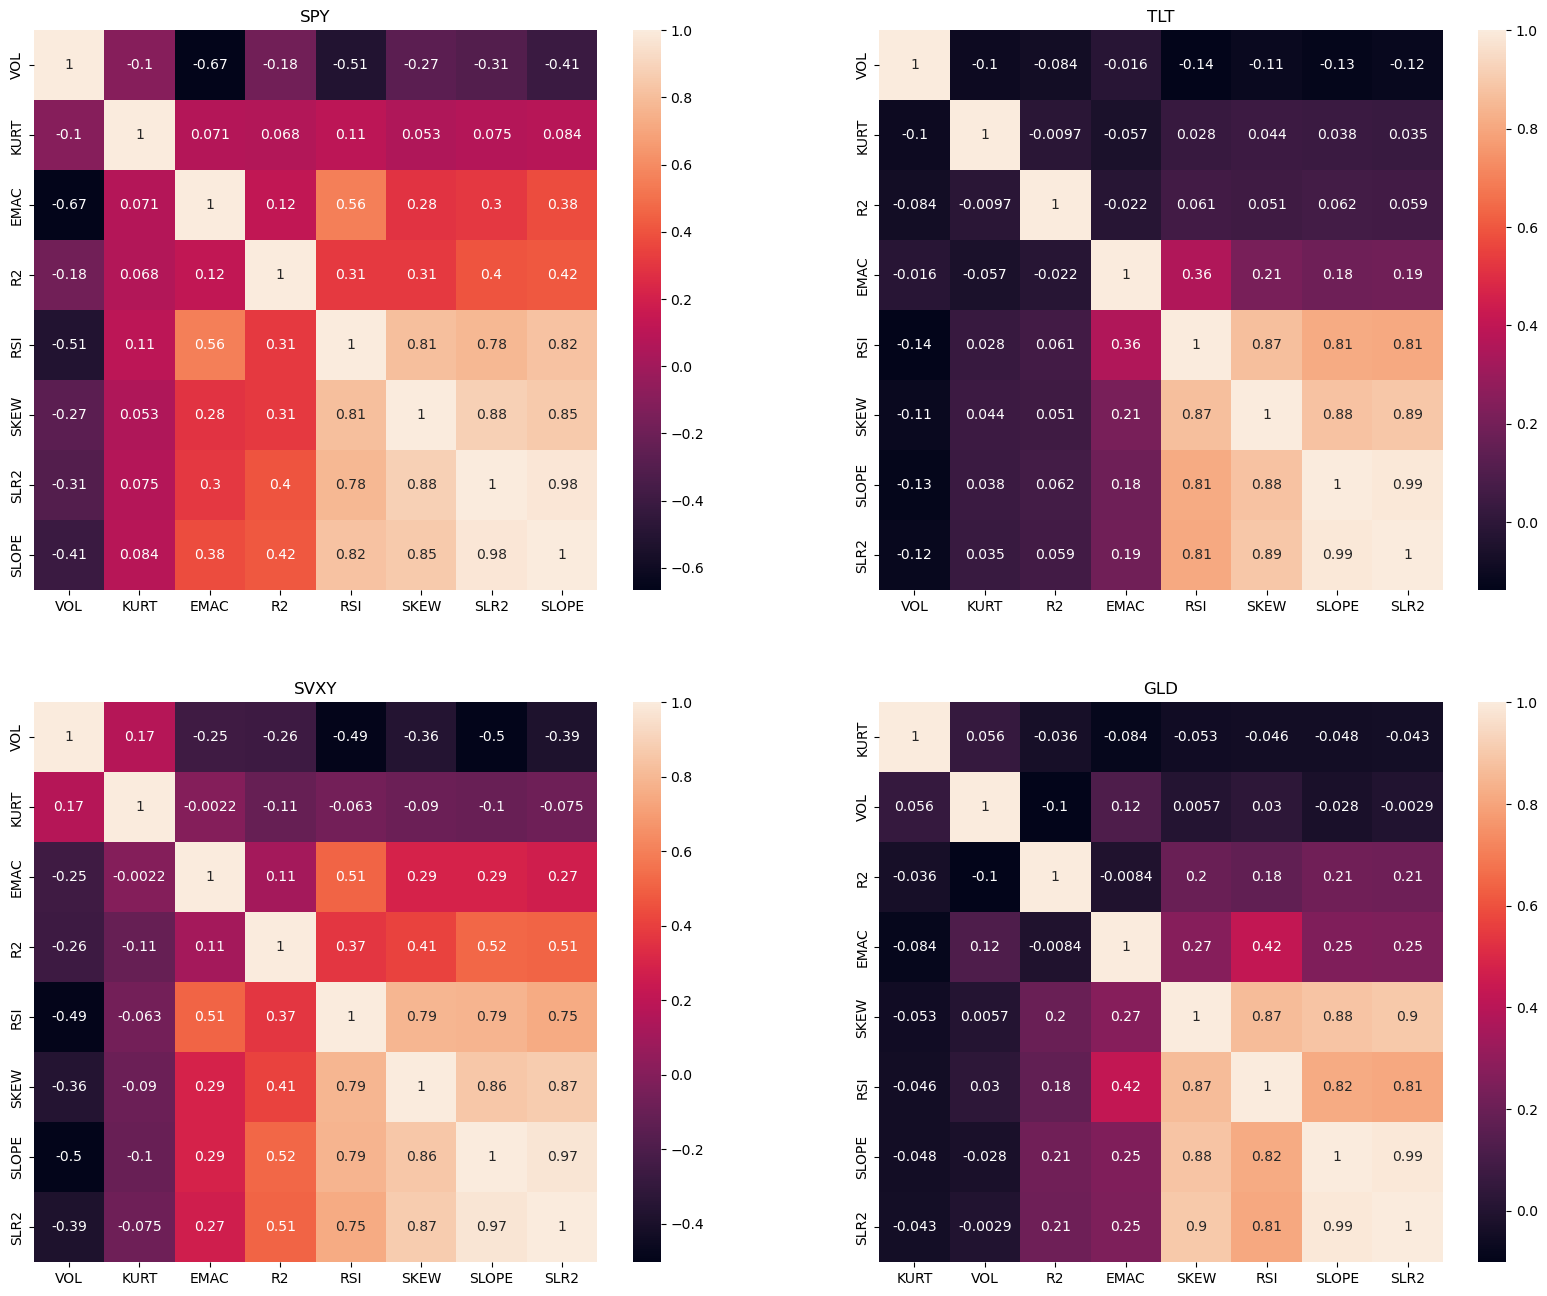

In [116]:
fig,axes = plt.subplots(2,2,figsize=(20,16))
for i,symbol in enumerate(symbols):
    ax = axes[i//2,i%2]
    ax.set_title(symbol)

    feat = all_feat[symbol]
    #corr = feat.corr(method='pearson')
    corr = feat.corr(method='spearman')
    avg_corr = corr.mean().sort_values(ascending=True)
    print(f'{symbol} avg corr:')
    print(np.around(avg_corr,2).to_dict())
    
    sns.heatmap(corr.loc[avg_corr.index,avg_corr.index], annot=True, ax=ax)

# Triple-barrier Label
### Use upper, lower, and time bounds to determine whether a trend is established

1. Upper bound is defined as a positive number times volatility. When the cumulative return touched upper bound, it is considered an uptrend.

2. Lower bound is defined as a negative number times volatility. When the cumulative return touched lower bound, it is considered a downtrend.

3. Time bound is defined as a fixed holding horizon. When the holding days touched time bound, it is considered no trend within the period

$Label = \left\{
  \begin{array}{ c l }
    +1 & \quad \textrm{if cumulative return >= upper bound} \\
    -1 & \quad \textrm{if cumulative return <= lower bound} \\
    0 & \quad \textrm{if holding days >= time bound and none of vertical bounds are touched}
  \end{array}
\right.$


### Rolling approach

In [117]:
def get_label(logprc,window):
  logret = logprc.diff().shift(-1)
  vol = logret.rolling(20).std()

  tp = window ** 0.5
  sl = window ** 0.5
  hd = window

  #print(tp , sl , hd)
  label = []

  for i,ret in logret.items():
    up_bar = vol.loc[i] * tp
    low_bar = vol.loc[i] * -sl
    time_bar = hd

    future_ret = logret.loc[i:]
    cum_ret = ret
    cum_day = 1
    while True:
      if cum_ret >= up_bar:
        label.append(1)
        break
      elif cum_ret <= low_bar:
        label.append(-1)
        break
      elif cum_day >= time_bar or cum_day >= future_ret.shape[0]:
        label.append(0)
        break

      ret = future_ret.iloc[cum_day]
      cum_day += 1
      cum_ret += ret

  label = pd.Series(label , index=logret.index , name='LABEL')
  return label

### Vectorized approach

In [66]:
def get_label(logprc,window):
    logret = logprc.diff().shift(-1)
    vol = logprc.diff().rolling(60).std()

    tp = window ** 0.5
    sl = window ** 0.5
    hd = window

    time_bar = hd
    up_bar = (tp * vol).iloc[:-time_bar] # drop last n days as the labelling is forward looking
    low_bar = (-sl * vol).iloc[:-time_bar] # drop last n days as the labelling is forward looking

    # vectorize approach to run rolling Labelling
    # create rolling datasets for each day
    rolling = sliding_window_view(logret, window_shape = time_bar)
    cumret = rolling.cumsum(axis=1)[:-1]
    max_cumret = cumret.max(axis=1)
    min_cumret = cumret.min(axis=1)

    is_up = np.where(max_cumret >= up_bar, 1, 0)
    is_low = np.where(min_cumret <= low_bar, -1, 0)
    label = pd.Series(is_up + is_low, index=up_bar.index, name='LABEL')
    return label

###

In [118]:
all_label = dict()
for symbol in symbols:
  data = all_data[symbol]
  label = get_label(data,window=lookback)
  all_label[symbol] = label

### Visualize the labelling method (sanity check)
<font color='green'>Green</font> zone means there is an uptrend identified. <br>
<font color='red'>Red</font> zone means there is an downtrend identified. <br>
<font color='gray'>Gray</font> zone means there is no obvious trend. <br>

Green = Uptrend
Red   = Downtrend
Gray  = No trend
(Here shows the label every 20 days for visibility, but it is updated everyday)


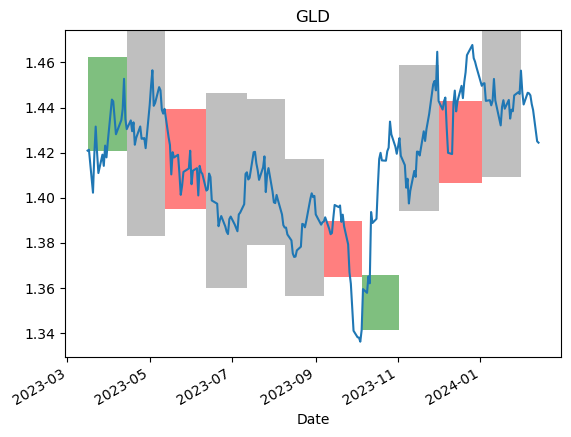

In [120]:
from matplotlib.patches import Rectangle

cum_ret = data.diff().shift(-1).cumsum()
vol = data.diff().rolling(60).std()

up_bar = lookback**0.5 * vol
low_bar = lookback**0.5 * vol
time_bar = lookback

period = cum_ret.index[-250:-time_bar]
dates = cum_ret.loc[period].index

sub_label = label.loc[period][::time_bar]
sub_cum_ret = cum_ret.loc[period]

ax = sub_cum_ret.plot(title=symbol)

print('Green = Uptrend')
print('Red   = Downtrend')
print('Gray  = No trend')
print(f'(Here shows the label every {time_bar} days for visibility, but it is updated everyday)')

for i,lab in enumerate(sub_label):
  if i+1 >= len(sub_label): break

  if lab == 1:
    w = sub_label.index[i+1] - sub_label.index[i]
    h = up_bar.loc[sub_label.index[i]]
    x = sub_label.index[i]
    y = sub_cum_ret[sub_label.index[i]]

    rect = Rectangle((x,y),w,h,
                     facecolor='g',alpha=0.5)
    ax.add_patch(rect)
  elif lab == -1:
    w = sub_label.index[i+1] - sub_label.index[i]
    h = up_bar.loc[sub_label.index[i]]
    x = sub_label.index[i]
    y = sub_cum_ret[sub_label.index[i]] - h

    rect = Rectangle((x,y),w,h,
                     facecolor='r',alpha=0.5)
    ax.add_patch(rect)
  elif lab == 0:
    w = sub_label.index[i+1] - sub_label.index[i]
    h = up_bar.loc[sub_label.index[i]] * 2
    x = sub_label.index[i]
    y = sub_cum_ret[sub_label.index[i]] - h/2

    rect = Rectangle((x,y),w,h,
                     facecolor='gray',alpha=0.5)
    ax.add_patch(rect)

# Concat features and label into one dataframe

In [121]:
all_dataset = dict()
for symbol in symbols:
    label = all_label[symbol]
    feat = all_feat[symbol]
    dataset = pd.concat([label, feat], axis=1).dropna()
    all_dataset[symbol] = dataset

# Random Forest Prediction
### Here run a walk-forward testing to evaluate the predictability

**Model setting (arbitrary)**
- `random_state = 300300`
- `n_estimators = 1000`
- `max_depth = 3`

**Training setting (arbritrary)**
- `step = lookback` - the model is retrained every n days
- `train_size = 1250 - lookback` - last 5 years minus the last n days used for labelling to avoid looking ahead

In [122]:
from sklearn.ensemble import RandomForestClassifier

train_size = 1250
step = lookback

all_rf_pred = dict()
all_rf_prob = dict()

for symbol in symbols:
  print(symbol)
  rf_pred_list = []
  rf_prob_list = []

  dataset = all_dataset[symbol]
  for start in range(train_size , len(dataset) , step):
    # rolling train set
    train_set = dataset.iloc[start - train_size : start - lookback] 
    # expanding train set
    #train_set = dataset.iloc[ : start].loc[train_set.index] 
    test_set = dataset.iloc[start : start + step]

    train_y , train_x = train_set['LABEL'] , train_set.drop(columns='LABEL')
    test_x = test_set.drop(columns='LABEL')

    rf = RandomForestClassifier(random_state=300300,
                                n_estimators=1000,
                                max_depth=3)
    rf.fit(X=train_x , y=train_y)
    
    # append the output from model to a list, concat them later
    rf_pred_list.append(pd.Series(rf.predict(X=test_x) , index=test_x.index))
    rf_prob_list.append(pd.DataFrame(rf.predict_proba(X=test_x) , index=test_x.index , columns=np.sort(train_y.unique())))

  rf_pred = pd.concat(rf_pred_list , name='PRED')
  rf_prob = pd.concat(rf_prob_list)
  all_rf_pred[symbol] = rf_pred
  all_rf_prob[symbol] = rf_prob

SPY


KeyboardInterrupt: 

# Evaluate performance

### Confusion Matrix
##### Here show the accuracy of each class of prediction
For example: <br>
$\%\ True\ Up=\frac{Number\ of\ True\ Up}{Number\ of\ Predicted\ Up}$ <br> <br>
$\%\ False\ Up=\frac{Number\ of\ True\ Down}{Number\ of\ Predicted\ Up}$

**Result**
1. Among all prediction of no trend, around a half is missed trend <br>

2. Prediction of downtrend is more accurate, 3 of 4 markets shows a higher relative accuracy* <br>

*An inituitive guess: Value of volatility (`VOL`) is less ambigious during market turmoil*<br>

*$Relative\ Accuracy\ of\ Up=\frac{\%\ True\ Up}{\%\ False\ Up}$ <br>

In [ ]:
from sklearn.metrics import confusion_matrix

def get_conf_mat(y_pred,y_true,k_list=None,pred_rate=False):
  if k_list is None:
    k_list = np.sort(y_true.unique())
  cm = pd.DataFrame(confusion_matrix(y_pred=y_pred,y_true=y_true),
                    index=pd.Index(k_list,name='True'),
                    columns=pd.Index(k_list,name='Pred'))
  if pred_rate:
    cm = np.around(cm.div(cm.sum(axis=0) , axis=1),2)
  return cm

In [ ]:
for symbol in symbols:
  pred_true = pd.DataFrame({'Pred':all_rf_pred[symbol],
                            'True':all_dataset[symbol].loc[:,'LABEL']}).dropna()
  cm = get_conf_mat(y_pred=pred_true['Pred'],
                    y_true=pred_true['True'],
                    k_list=['up','none','down'],
                    pred_rate=True)
  print(f'======== {symbol} ========')
  print(cm)
  print()

======== SPY ========
Pred    up  none  down
True                  
up    0.24  0.23  0.25
none  0.41  0.53  0.45
down  0.34  0.24  0.31

======== TLT ========
Pred    up  none  down
True                  
up    0.23  0.23  0.23
none  0.55  0.52  0.39
down  0.22  0.26  0.38

======== SVXY ========
Pred    up  none  down
True                  
up    0.31  0.12  0.18
none  0.35  0.59  0.62
down  0.34  0.29  0.20

======== GLD ========
Pred    up  none  down
True                  
up    0.26  0.22  0.26
none  0.38  0.48  0.37
down  0.36  0.31  0.37



### Profitability

In [ ]:
def get_pos(pred,prob,logret,
            tp,sl,hd,p_thr=None):
  vol = logret.rolling(20).std()

  if p_thr is None:
    p_thr = 1 / prob.shape[1] # 1/n for n class
  
  #print(tp , sl , hd)
  pos = []
  in_pos = False
  
  for i,pred_i in pred.items():
    if not in_pos and pred_i != 0 and prob.loc[i,pred_i] >= p_thr:
      up_bar = vol.loc[i] * tp
      low_bar = vol.loc[i] * -sl
      time_bar = hd

      #future_ret = logret.loc[i:]
      cum_ret = pred_i * logret.loc[i]
      cum_day = 1
      pos.append(pred_i)
    elif in_pos:
      # break if any of bar is touched
      if cum_ret >= up_bar:
        in_pos = False
      elif cum_ret <= low_bar:
        in_pos = False
      elif cum_day >= time_bar:
        in_pos = False
      else:
        # update cum_ret and cum_day if no bar is touched
        cum_ret += pred_i * logret.loc[i]
        cum_day += 1
        pos.append(pred_i)
    else:
      pos.append(0)
        
  pos = pd.Series(pos , index=pred.index , name='POS')
  return pos

In [109]:
def get_pnl(pred,prob,logret,
            tp,sl,hd,p_thr=None,
            trail_sl=False):
  vol = logret.rolling(20).std()

  if p_thr is None:
    p_thr = 1 / prob.shape[1] # 1/n for n class
  
  #print(tp , sl , hd)
  pnl = []
  in_pos = False
  
  for i,pred_i in pred.items():
    if not in_pos and pred_i != 0 and prob.loc[i,pred_i] >= p_thr:
      up_bar = vol.loc[i] * tp
      low_bar = vol.loc[i] * -sl
      time_bar = hd

      #future_ret = logret.loc[i:]
      cum_ret = pred_i * logret.loc[i]
      cum_day = 1
      pnl.append(pred_i * logret.loc[i])
    elif in_pos:
      # break if any of bar is touched
      if cum_ret >= up_bar:
        in_pos = False
      elif cum_ret <= low_bar:
        in_pos = False
      elif cum_day >= time_bar:
        in_pos = False
      elif prob.loc[i,pred_i] < p_thr:
        in_pos = False
      else:
        # update cum_ret and cum_day if no bar is touched
        cum_ret += pred_i * logret.loc[i]
        cum_day += 1
        if trail_sl and pred_i * logret.loc[i] > 0:
          low_bar += pred_i * logret.loc[i]
        pnl.append(pred_i * logret.loc[i])
    else:
      pnl.append(0)
        
  pnl = pd.Series(pnl , index=pred.index , name='PNL')
  return pnl

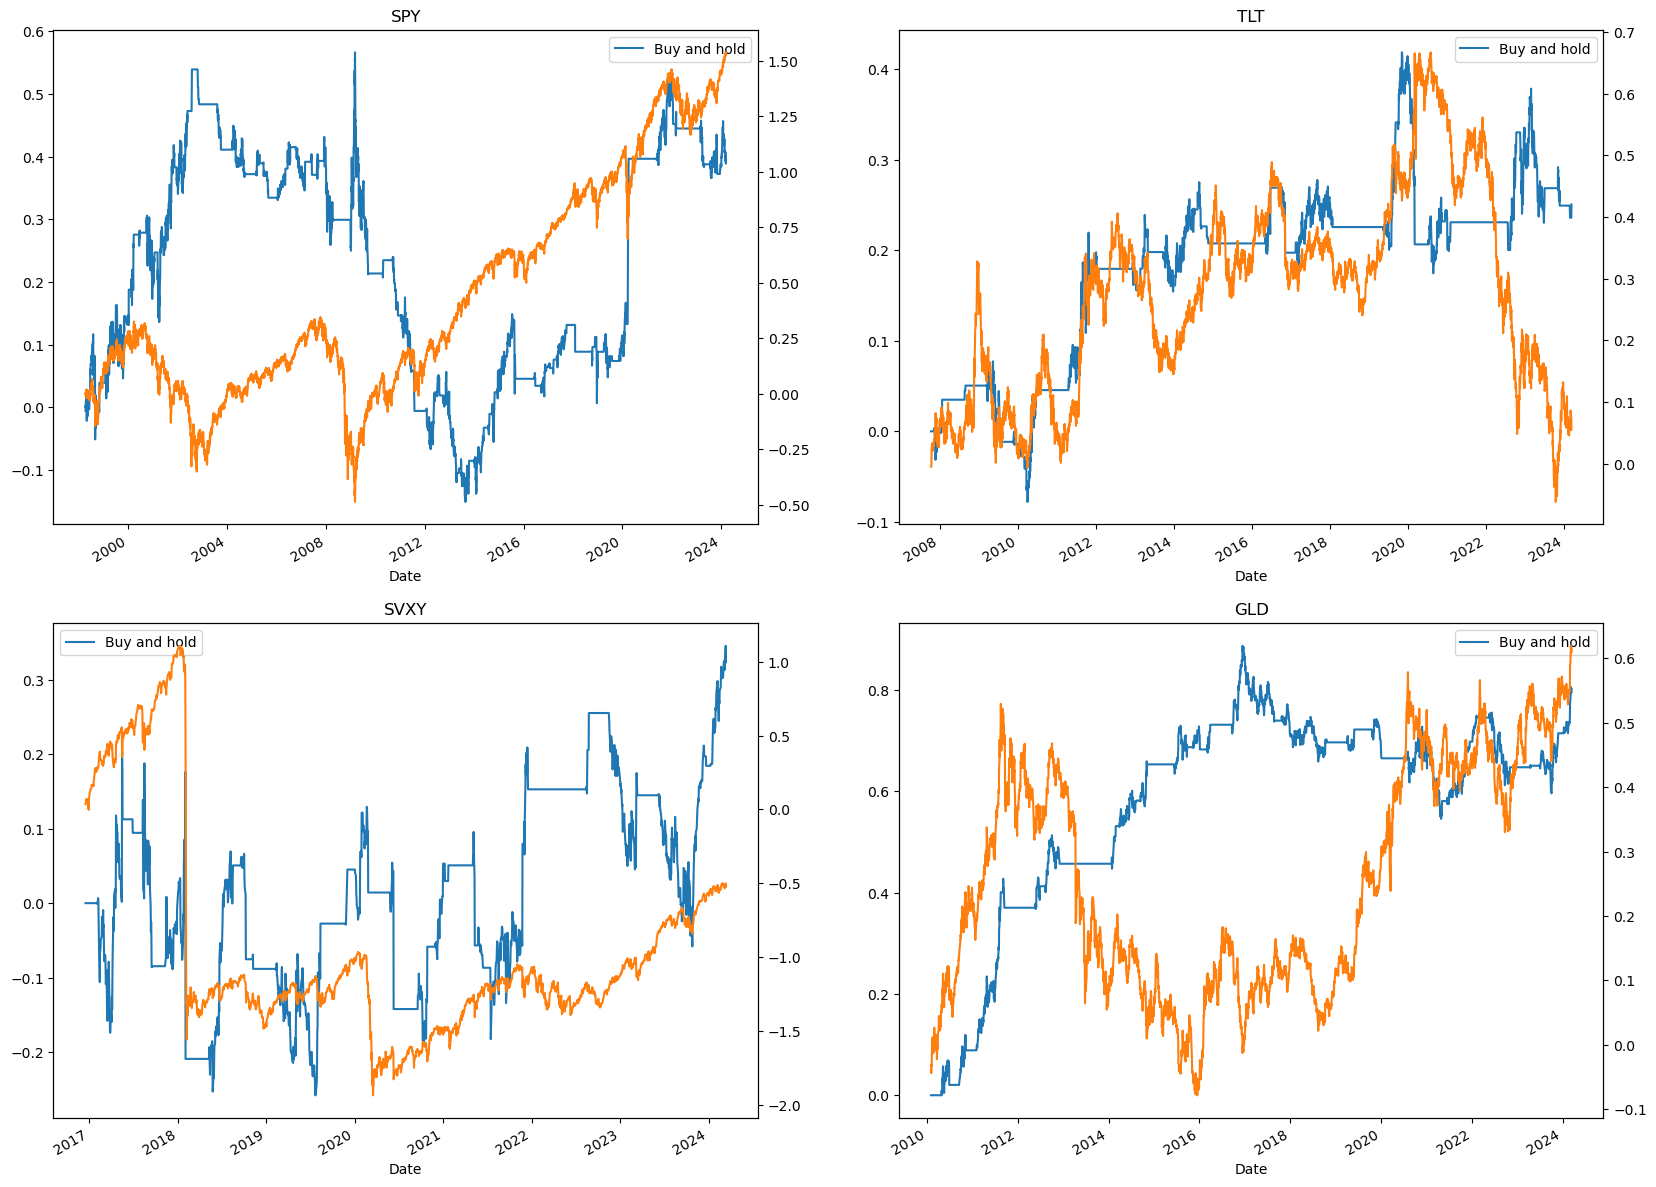

In [114]:
tp = lookback ** 0.5
sl = lookback ** 0.5 # stop loss can be tighter in real trading compared to labelling
hd = lookback ** 0.5

port_pnl = pd.DataFrame()

fig,axes = plt.subplots(2,2,figsize=(20,16))
for i,symbol in enumerate(symbols):
  logret = all_data[symbol].diff().shift(-1)
  pred = all_rf_pred[symbol]
  prob = all_rf_prob[symbol]
  #pos = get_pos(pred,prob,logret,
  #              tp,sl,hd)
  # rolling mean simulate open a position with 1/n capital and holding it for n days
  #pnl = pos.rolling(lookback).mean() * logret
  pnl = get_pnl(pred,prob,logret,
                tp,sl,hd,
                trail_sl=True)
  port_pnl[symbol] = pnl
  
  ax = axes[i//2 , i%2]
  ax.set_title(symbol)
  start_day = pnl.dropna().index[0]
  pnl.loc[start_day:].cumsum().plot(ax=ax)
  logret.loc[start_day:].cumsum().plot(ax=ax, secondary_y=True)
  ax.legend(['Buy and hold','Strategy'])

In [19]:
def get_pos(pred,prob):
  l = np.where(pred == 1 , 1 * prob.iloc[:,2] , 0)
  s = np.where(pred == -1 , -1 * prob.iloc[:,0] , 0)
  pos = pd.Series(l + s , index=pred.index)
  return pos

In [22]:
def scale_vol(pnl):
  vol = pnl.std()
  scalar = .20 / 16 / vol
  scaled_pnl = pnl * scalar
  return scaled_pnl

In [21]:
probpos = get_pos(all_rf_pred['AUDUSD=X'],all_rf_prob['AUDUSD=X'])

In [ ]:
def get_pnl(pos,prob,logret,window=None,tp=None,sl=None,hd=None):
  vol = logret.rolling(60).std()

  pnl = []
  in_pos = False
  
  for i,p in pos.items():
    ret = logret.loc[i]
    if not in_pos and p!=0 and prob.loc[i,p+1]>=0.5:
      up_bar = vol.loc[i] * tp
      low_bar = vol.loc[i] * -sl
      horzn_bar = hd

      cum_ret = p * ret
      cum_day = 1
    elif in_pos:
      cum_ret += p * ret
      cum_day += 1
      pnl.append(p * ret)
      
      if cum_ret >= up_bar or cum_ret <= low_bar or cum_day >= horzn_bar or prob.loc[i,p+1]<0.5:
        in_pos = False
    else:
      pnl.append(0)

  pnl = pd.Series(pnl , index=pos.index , name='LABEL')
  return pnl

In [ ]:
all_rf_pred['AUDUSD=X'] 

Date
2010-05-18    1
2010-05-19    1
2010-05-20    1
2010-05-21    1
2010-05-24    1
             ..
2024-03-08    1
2024-03-11    1
2024-03-12    1
2024-03-13    1
2024-03-14    1
Length: 3602, dtype: int64

2 2 20


<Axes: xlabel='Date'>

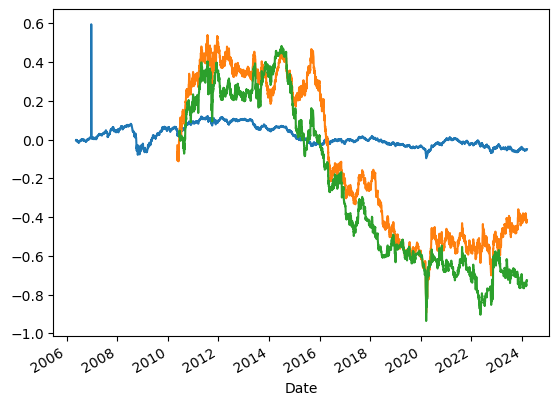

In [62]:
logret = all_data['AUDUSD=X'].diff().shift(-1)
pnl = get_pnl(all_rf_pred['AUDUSD=X'] , all_rf_prob['AUDUSD=X'] , logret , tp=2 , sl=2 , hd=20)
prob_pnl = probpos.rolling(20).mean() * logret

scale_vol(logret).cumsum().plot()
scale_vol(pnl).cumsum().plot()
scale_vol(prob_pnl).cumsum().plot()

In [ ]:
with open('all_rf_pred.pickle', 'wb') as handle:
    pickle.dump(all_rf_pred, handle, protocol=pickle.HIGHEST_PROTOCOL)
#!cp all_rf_pred.pickle "drive/My Drive/"

with open('all_rf_prob.pickle', 'wb') as handle:
    pickle.dump(all_rf_prob, handle, protocol=pickle.HIGHEST_PROTOCOL)
#!cp all_rf_prob.pickle "drive/My Drive/"

In [ ]:
with open('all_rf_pred.pickle', 'rb') as handle:
    all_rf_pred = pickle.load(handle)

with open('all_rf_prob.pickle', 'rb') as handle:
    all_rf_prob = pickle.load(handle)

In [ ]:
all_rf_pred

{}

Elapsed time to compute the importances: 20.575 seconds


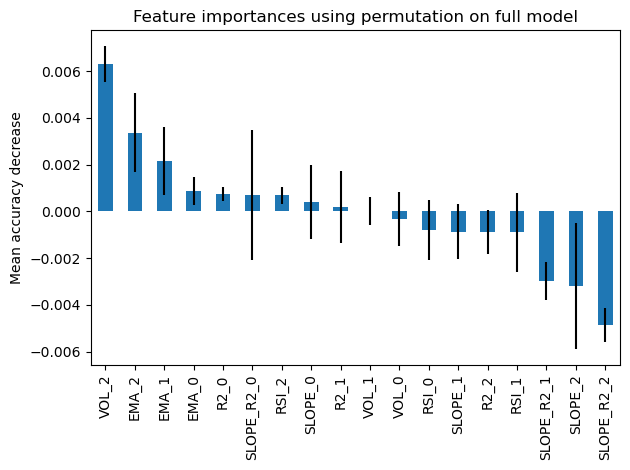

In [25]:
from sklearn.inspection import permutation_importance

start_time = time.time()
feature_names = test_x.columns
result = permutation_importance(
    rf, big_train_x, big_train_y, n_repeats=10, random_state=300300, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
mac_pred = data.ewm(20).mean() - data.ewm(80).mean()

In [ ]:
thr = 0.3
mac_pos = pd.Series(np.where(mac_pred > 0 , 1 , -1) , index=mac_pred.index)
rf_pos = rf_pred.copy().rolling(20).mean()

In [ ]:
logret = data.diff().shift(-1)

mac_pnl = mac_pos * logret
rf_pnl = rf_pos * logret

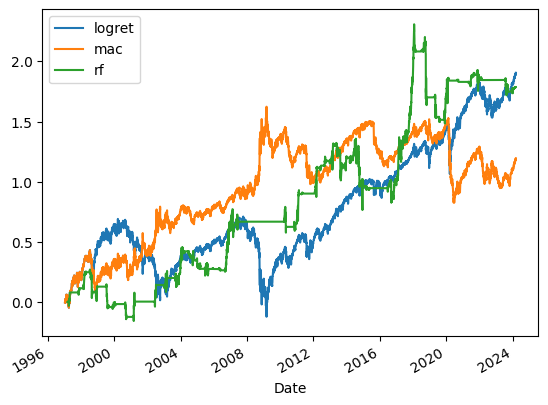

In [ ]:
period = data.index[1000:]

logret.loc[period].cumsum().plot()
mac_pnl.loc[period].cumsum().plot()
(rf_pnl.loc[period]*7).cumsum().plot()

plt.legend(['logret','mac','rf'])

In [ ]:
e = Evaluator(rf_pnl*7)
e.get_summary()

nan 0.03215926493108729


,Value,Sample size,P-value
CAGR,NaN,7836.0000,NaN
Mean,0.0662,7836.0000,NaN
Vol,0.2145,7836.0000,NaN
SR,0.3089,7836.0000,0.0000
CAPM Alpha,0.1774,2419.0000,0.1261
Carhart Alpha,0.1825,2419.0000,0.1175
Beta,-0.1306,2419.0000,0.0136
Skew,-1.9325,7836.0000,NaN
Skew (M),-0.3640,375.0000,NaN
Kurt,38.4076,7836.0000,NaN
